### Accuracy distributions by read and by site (swarm plots)

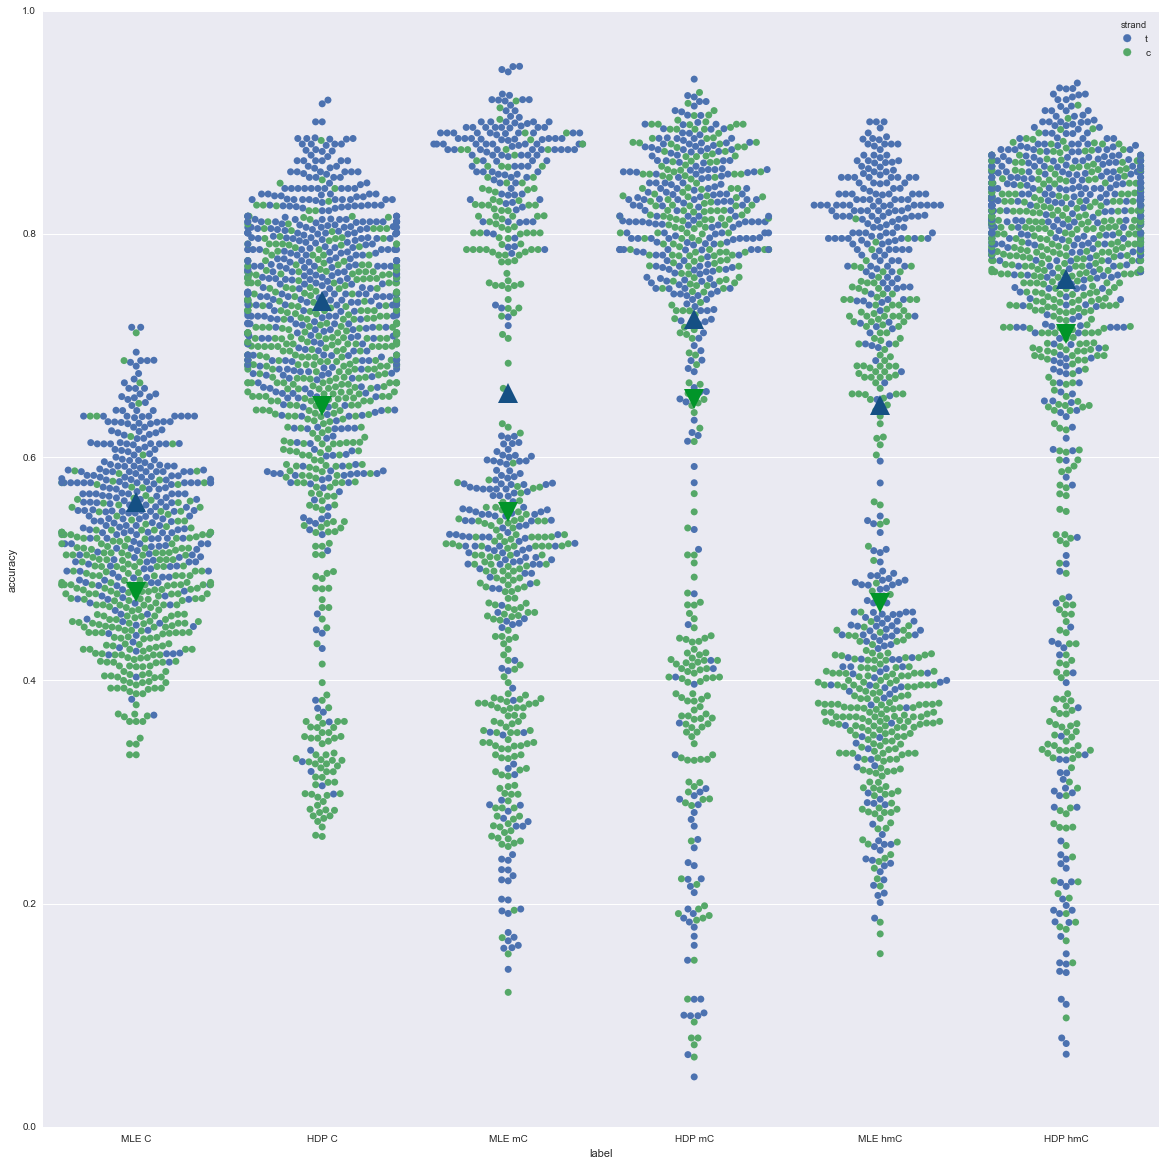

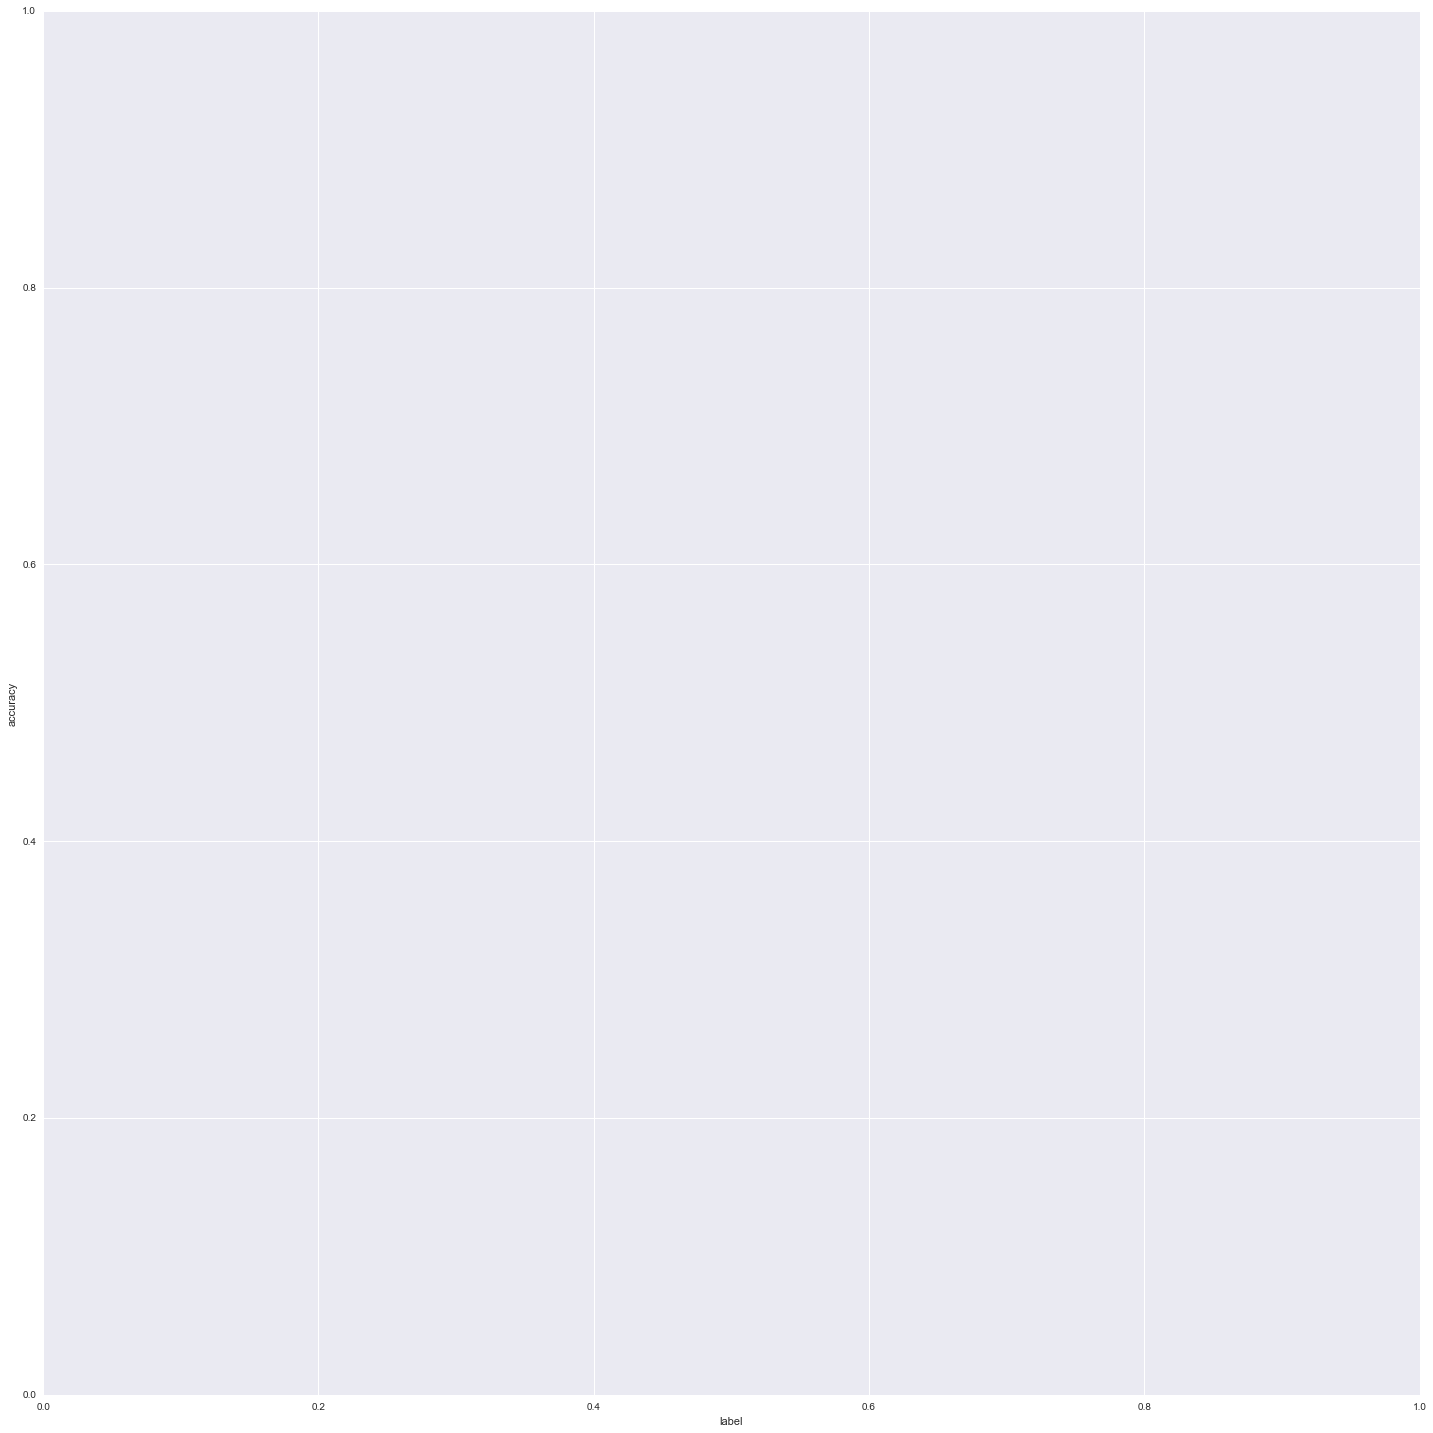

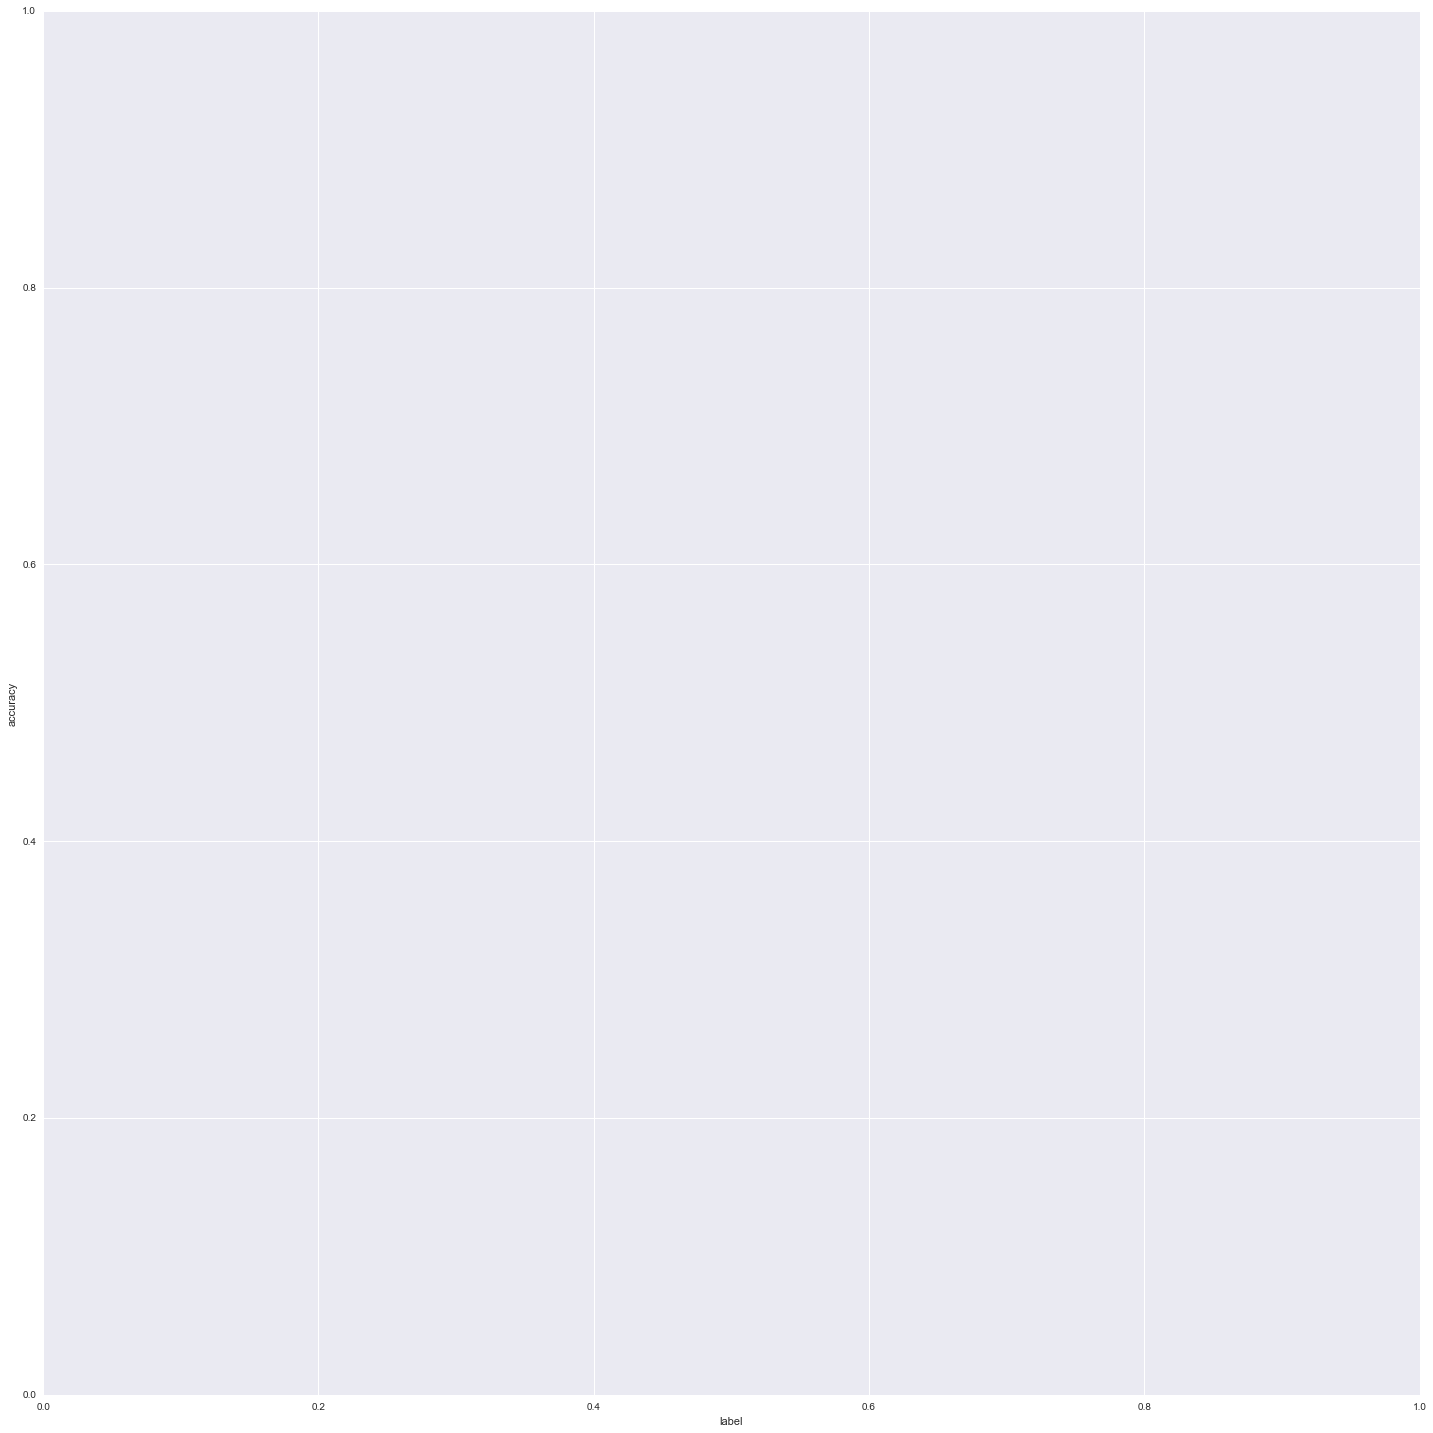

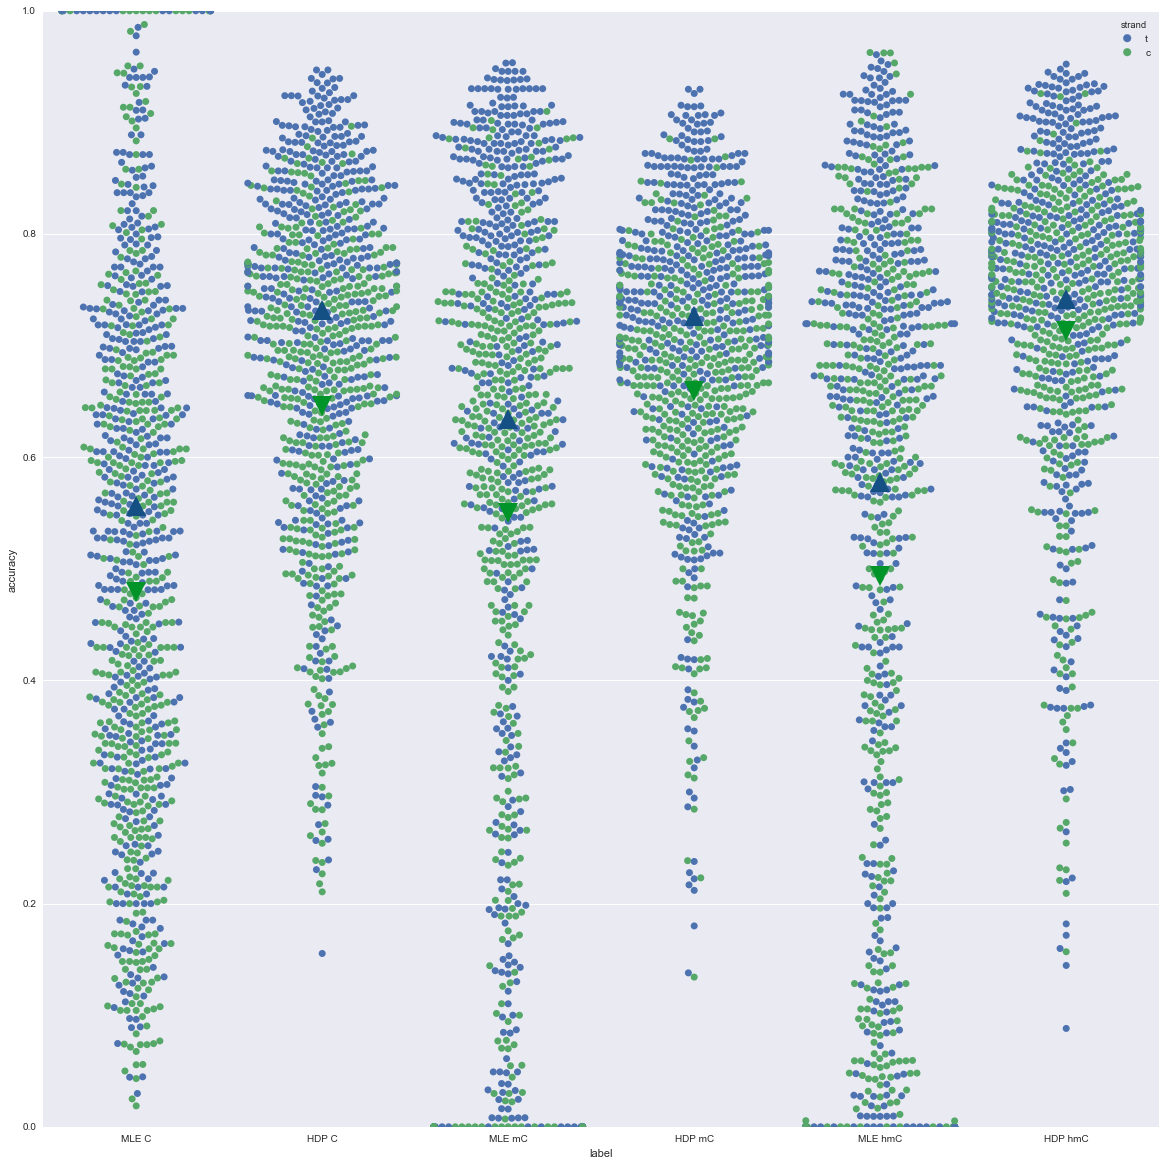

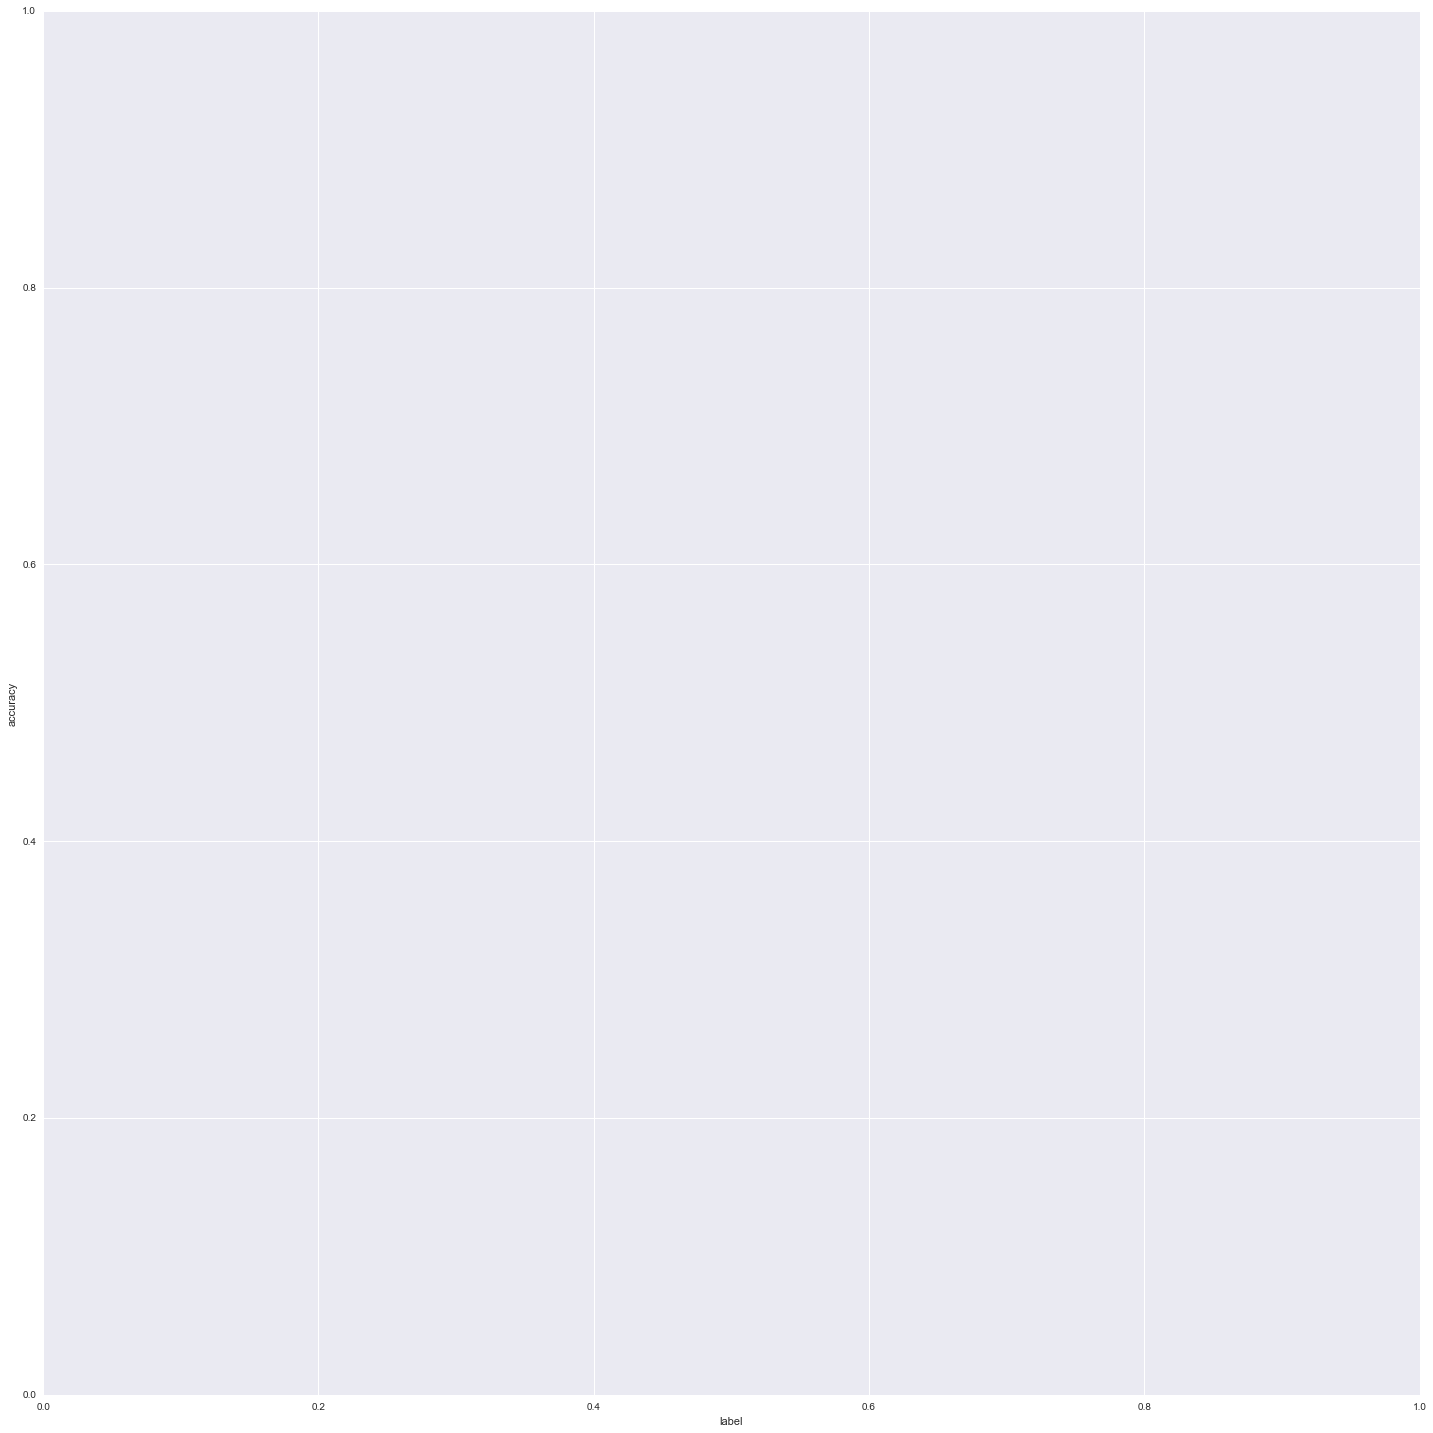

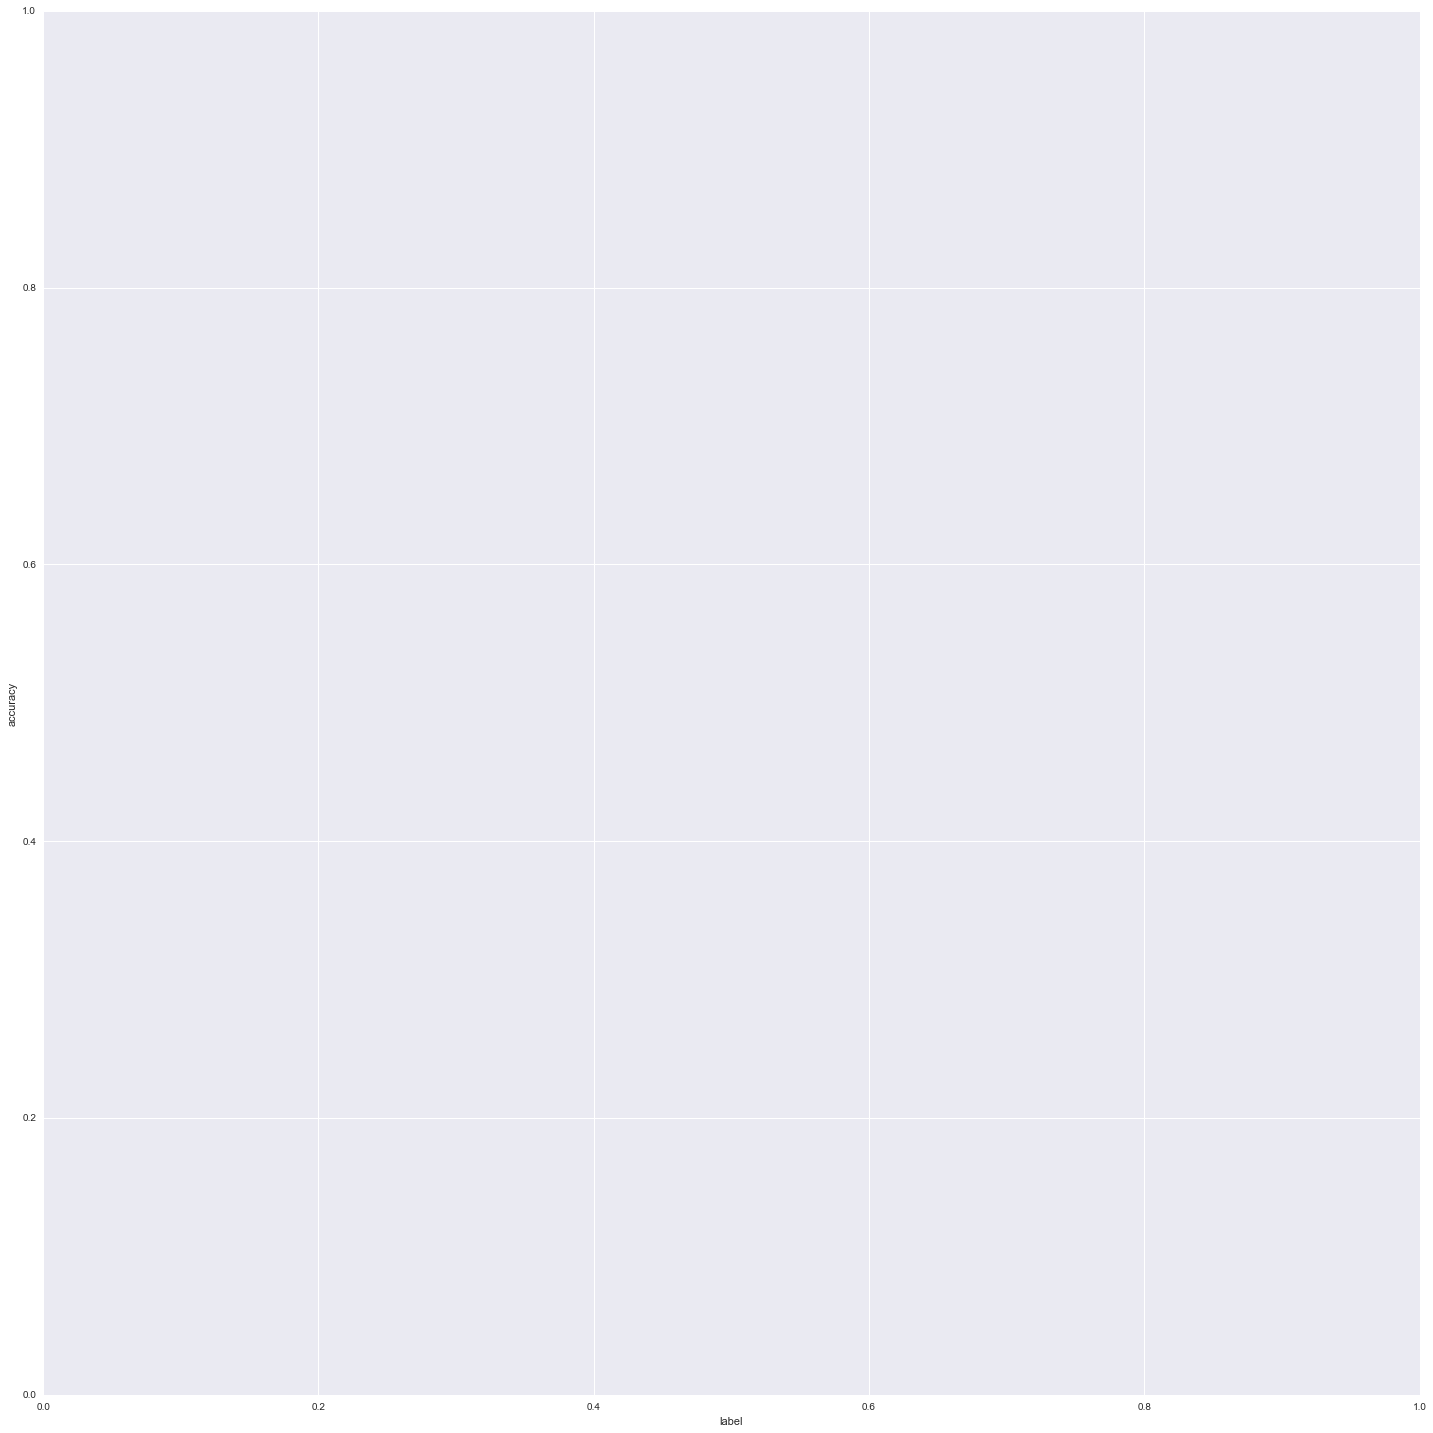

In [11]:
from __future__ import division
import sys
sys.path.append("../")
#from zymoAnalysis import *
#from sklearn.metrics import confusion_matrix, roc_curve
#from ggplot import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(style="whitegrid", palette="muted")

%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 20

def load_data(file_path):
    data = pd.read_table(file_path,
                         usecols=(0, 1, 2, 3, 4, 5),
                         names=['site', 'strand', 'pC', 'pmC', 'phmC', 'read'],
                         dtype={'site': np.int64,
                                'strand': np.str,
                                'pC': np.float64,
                                'pmC': np.float64,
                                'phmC': np.float64,
                                'read': np.str,
                               })
    return data


def get_calls(data, strand):
    select_by_strand = data.ix[data['strand'] == strand]
    calls = []
    for row in select_by_strand.itertuples():
        call = np.argmax(row[3:6])
        calls.append(call)
    return calls


def get_accuracy_by_category(data, category, strand, label):
    read_accuracies = []
    categories = []
    for read in data.groupby([category]):
        calls = get_calls(read[1], strand)
        if not calls:
            continue
        total_correct = calls.count(label)
        total = len(calls)
        categories.append(str(read[0]))
        read_accuracies.append(total_correct / total)
    return read_accuracies, categories


def package_means_into_df(data, category, label, strand):
    acc, cats = get_accuracy_by_category(data, category, strand, label['label'])
    df = pd.DataFrame(index=range(1), columns=['label', 'accuracy', 'strand'])
    df['label'] = label['name']
    df['accuracy'] = np.mean(acc)
    df['strand'] = strand
    return df


def package_accuracies_into_df(data, category, label, strand):
    acc, cats = get_accuracy_by_category(data, category, strand, label['label'])
    df = pd.DataFrame(index=range(len(acc)), columns=['label', 'accuracy', 'strand', 'category'])
    df['label'] = label['name']
    df['accuracy'] = acc
    df['category'] = cats
    df['strand'] = strand
    return df


def get_dataset_for_swarmplot(c, mc, hmc, category, experiment):
    c_label = {'name': '{} C'.format(experiment), 'label': 0}
    c_df = pd.concat([package_accuracies_into_df(c, category, c_label, 't'),
                      package_accuracies_into_df(c, category, c_label, 'c')])
    c_df_u = pd.concat([package_means_into_df(c, category, c_label, 't'),
                        package_means_into_df(c, category, c_label, 'c')])

    mc_label = {'name': '{} mC'.format(experiment), 'label': 1}
    mc_df = pd.concat([package_accuracies_into_df(mc, category, mc_label, 't'),
                       package_accuracies_into_df(mc, category, mc_label, 'c')])
    mc_df_u = pd.concat([package_means_into_df(mc, category, mc_label, 't'),
                         package_means_into_df(mc, category, mc_label, 'c')])

    hmc_label = {'name': '{} hmC'.format(experiment), 'label': 2}
    hmc_df = pd.concat([package_accuracies_into_df(hmc, category, hmc_label, 't'),
                        package_accuracies_into_df(hmc, category, hmc_label, 'c')])
    hmc_df_u = pd.concat([package_means_into_df(hmc, category, hmc_label, 't'),
                          package_means_into_df(hmc, category, hmc_label, 'c')])

    return (c_df, mc_df, hmc_df), (c_df_u, mc_df_u, hmc_df_u)


def swarmplot_accuracies_by_category_with_mean(c, mc, hmc, c2, mc2, hmc2, category, exp, exp2, out_file=None):
    def mean_dot(in_data, strand):
        return sns.PairGrid(in_data.ix[in_data['strand'] == strand], y_vars="accuracy", x_vars=["label"], size=20)

    hdp_data, hdp_u = get_dataset_for_swarmplot(c, mc, hmc, category, exp)
    kde_data, kde_u = get_dataset_for_swarmplot(c2, mc2, hmc2, category, exp2)
    distributions = pd.concat([kde_data[0], hdp_data[0], kde_data[1], hdp_data[1], kde_data[2], hdp_data[2]])
    means = pd.concat([kde_u[0], hdp_u[0], kde_u[1], hdp_u[1], kde_u[2], hdp_u[2]])
    fig, ax = plt.subplots()
    p = sns.swarmplot(x="label", y="accuracy", hue="strand", data=distributions, ax=ax, size=7)
    g = mean_dot(means, 't')
    h = mean_dot(means, 'c')
    g.map(sns.stripplot, color=sns.xkcd_rgb["light navy"], ax=ax, size=20, marker="^", edgecolor='k')
    h.map(sns.stripplot, color=sns.xkcd_rgb["irish green"], ax=ax, size=20, marker="v", edgecolor='k')
    g.set(ylim=(0, 1))
    h.set(ylim=(0, 1))
    ax.set_ylim([0, 1])

    if out_file is not None:
        fig.savefig(out_file)
    



c_kde = load_data("../data/zymo/mle/C-barcoded_calls.tsv")
mc_kde = load_data("../data/zymo/mle/mC-barcoded_calls.tsv")
hmc_kde = load_data("../data/zymo/mle/hmC-barcoded_calls.tsv")
c_mulset = load_data("../data/zymo/multiset/C-barcoded_calls.tsv")
mc_mulset = load_data("../data/zymo/multiset/mC-barcoded_calls.tsv")
hmc_mulset = load_data("../data/zymo/multiset/hmC-barcoded_calls.tsv")

swarmplot_accuracies_by_category_with_mean(c_mulset, mc_mulset, hmc_mulset, 
                                           c_kde, mc_kde, hmc_kde, 
                                           'read', 'HDP', 'MLE', None)

swarmplot_accuracies_by_category_with_mean(c_mulset, mc_mulset, hmc_mulset, 
                                           c_kde, mc_kde, hmc_kde, 
                                           'site', 'HDP', 'MLE', None)




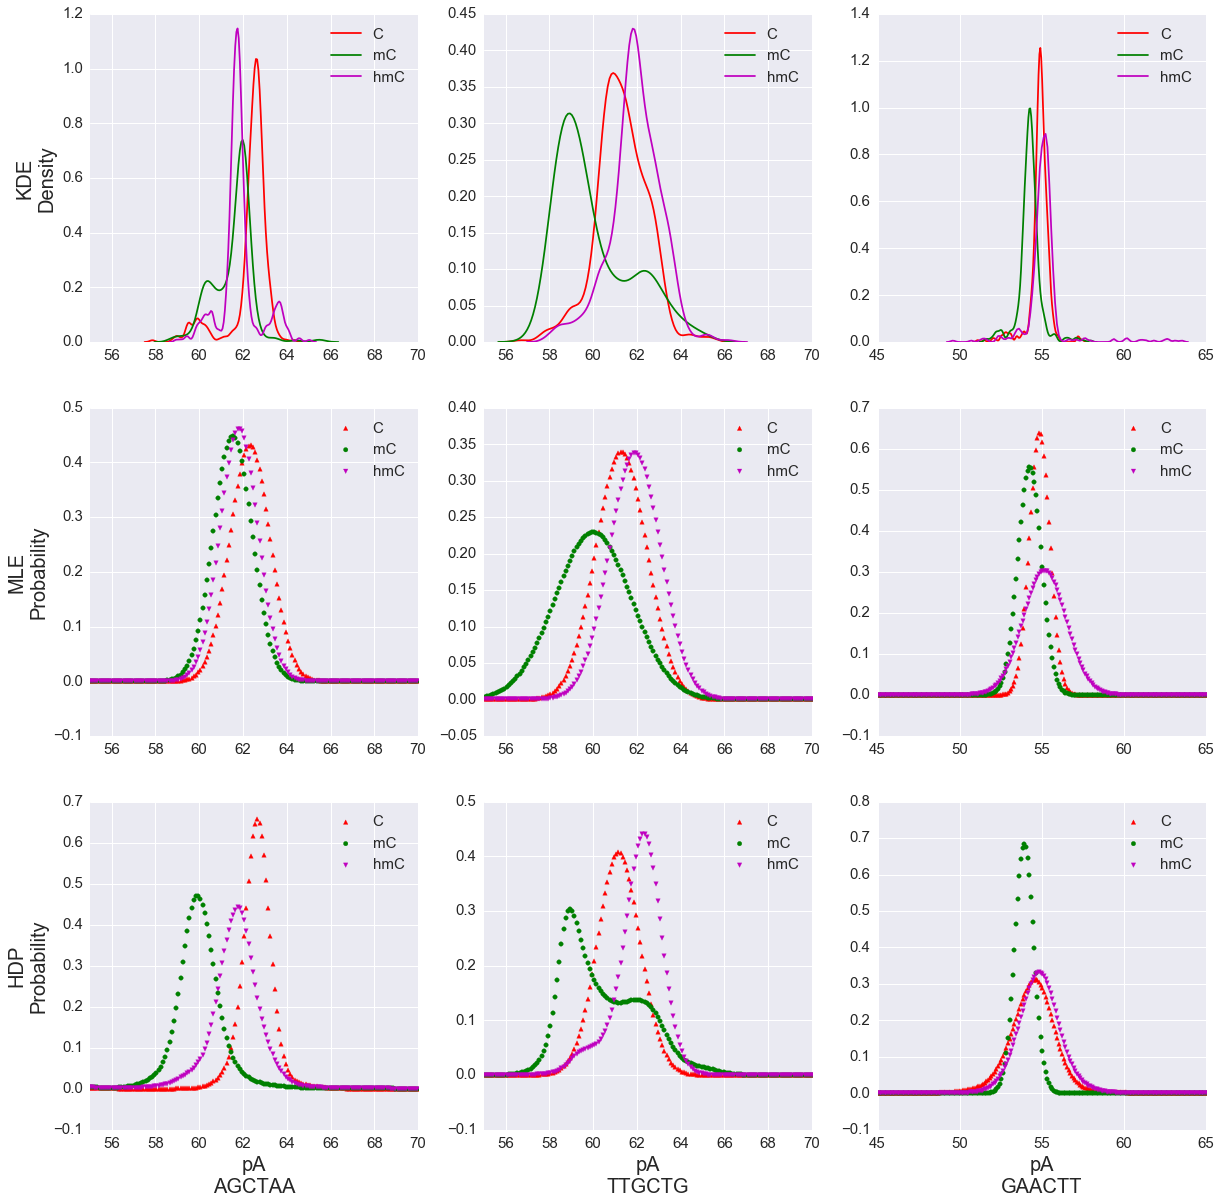

In [10]:
import sys 
sys.path.append("../")
from vis_kmer_distributions import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 20

NUM_VARIANTS = 3
# paths to histograms/distributions
hdp_distributions = "/Volumes/nanopore-working/zymo/signalAlign_results/03_24_hdpDistributions/noEM/multisetPrior_11_11_11/template_dist/"
sixmer_histograms = "/Volumes/nanopore-working/zymo/signalAlign_results/03_16_kmerHist/{variant}/template_hist/"
mle_hmm = "../data/zymo/hmm/template_kde.hmm"

x_vals = np.linspace(30, 90, 600) # x values for HDP 
# GAACTT good, similar
# TTGCTG good, dissimilar
# AGCTAA good, dissimilar

kmers = ["AGCTAA", "TTGCTG", "GAACTT"]

fig = plt.figure()

fig, ax = plt.subplots(3, 3)

# setup the axis on the plots
for x in range(3):
    for y in range(3):
        ax[x, y].yaxis.set_tick_params(labelsize=15)
        ax[x, y].xaxis.set_tick_params(labelsize=15)
col0_xaxis = [55, 70]
col3_xaxis = [45, 65]
# first column
ax[0, 0].set_xlim(col0_xaxis)
ax[0, 0].set_ylabel("KDE\nDensity", fontsize=20)
ax[1, 0].set_ylabel("MLE\nProbability", fontsize=20)
ax[1, 0].set_xlim(col0_xaxis) 
ax[2, 0].set_ylabel("HDP\nProbability", fontsize=20)
ax[2, 0].set_xlim([55, 70])
ax[2, 0].set_xlabel("pA\n{}".format(kmers[0]), fontsize=20)
# second column
ax[0, 1].set_xlim(col0_xaxis)
ax[1, 1].set_xlim(col0_xaxis)
ax[2, 1].set_xlim(col0_xaxis)
ax[2, 1].set_xlabel("pA\n{}".format(kmers[1]), fontsize=20)
# third column
ax[0, 2].set_xlim(col3_xaxis)
ax[1, 2].set_xlim(col3_xaxis)
ax[2, 2].set_xlim(col3_xaxis)
ax[2, 2].set_xlabel("pA\n{}".format(kmers[2]), fontsize=20)


# get MLE distributions
sixmer_mle_pdfs = [get_hmm_pdfs(x, mle_hmm, x_vals) for x in kmers]
# get HDP distributions
sixmer_hdp_distributions = [get_kmer_densities(hdp_distributions, x) for x in kmers]

colors = ['r', 'g', 'm']
markers = ['^', 'o', 'v']
labels = ['C', 'mC', 'hmC']

# plot the KDE row
for k in xrange(len(kmers)):    
    for v in xrange(NUM_VARIANTS):
        hist = KmerAlignmentHistogram(sixmer_histograms.format(variant=labels[v]), kmers[k])
        sns.distplot(hist.histogram, hist=False, rug=False, color=colors[v], ax=ax[0, k], label=labels[v])
        ax[0, k].legend(prop={'size':15})

# plot MLE row
for k in xrange(len(kmers)):
    for v in xrange(NUM_VARIANTS):
        ax[1, k].scatter(x_vals, sixmer_mle_pdfs[k][v], norm=True, color=colors[v], 
                         marker=markers[v], label=labels[v])
        ax[1, k].legend(prop={'size':15})
# plot HDP row
for k in xrange(len(kmers)):
    for v in xrange(NUM_VARIANTS):
        ax[2, k].scatter(x_vals, sixmer_hdp_distributions[k][v].density, norm=True, color=colors[v], 
                         marker=markers[v], label=labels[v])
        ax[2, k].legend(prop={'size':15})

plt.show()


